In [31]:
from notepad import WaterStorage, Heatpump
# from pyrecoy.forecasts import Mipf
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
import pandas as pd
import cufflinks
cufflinks.go_offline()
from numpy.polynomial import Polynomial

In [33]:
mipf = Mipf(
    start='2018-11-01', 
    end='2018-11-02', 
    tidy=False, 
    include_nextQ=False,
    folder_path=r"C:\Users\Shahla Huseynova\Recoy\Recoy - Documents\03 - Libraries\12 - Data Management\Forecast Data"
).data

price_data = mipf[['DAM', 'POS', 'NEG']]
price_data

NameError: name 'Mipf' is not defined

In [ ]:
data = pd.read_excel('Demand_Data_Smurfit_Preprocessed.xlsx', sheet_name='nov2018', index_col=0)
start, end = '2018-11-01 00:00:00', '2018-11-01 12:00:00'
df = data[start:end]
df = df.resample('15T', origin=start).mean()
df=df.drop(['Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11', 'Unnamed: 12'], axis=1)
df[:10]

In [ ]:
df[['Tsource (VDG)', 'Tsink (VDG)']].iplot()

In [34]:
waterstorage = WaterStorage(
    name='MyStorage',
    max_power=10,
    min_power=-10,
    roundtrip_eff=0.90,
    capacity_per_volume = 50 * 1e-3,
    volume = 1000,
    lifetime = 25,
    temperature = 368, #K
    min_storagelevel = 5,
    # max_storagelevel = 50
    
)
waterstorage.set_freq('15T')
waterstorage.set_storagelevel(15)
waterstorage.storagelevel


15

In [35]:
Tsink = 140  #Celcius
Tsource = 60
Tref = 0
hp_capacity = 31 #MW
process_demand_MW = 25 #MW
Cp = 4190.0  #J/kgK
MW_to_J_per_s = 1000000
hp_capacity *= MW_to_J_per_s
process_demand_MW *= MW_to_J_per_s
efficiency = 0.9
Tstorage = 95

In [36]:
waterstorage.max_storage_capacity

50.0

In [37]:
from numpy.polynomial import Polynomial

def hp_mass_flow (hp_capacity, Tsink, Tref, Cp):
    return hp_capacity /(Cp*(Tsink - Tref)) 

def process_mass_flow (process_demand_MW, Tsink, Tref, Cp):
    return process_demand_MW /(Cp*(Tsink - Tref)) 

def COP_calculation(Tsink, Tsource):
    return Tsink / (Tsink - Tsource)

def cop_curve(Tsink, Tsource):
    c0 = Tsink / (Tsink - Tsource)  
    return Polynomial([c0])

def charge_mass_flow(hp_mass_flow, process_mass_flow):
    return hp_mass_flow - process_mass_flow

def charged_heat (charge_mass_flow, Cp, Tsink, Tref):
    return charge_mass_flow * Cp * (Tsink - Tref) / MW_to_J_per_s

def discharged_heat(charged_heat, efficiency):
    return charged_heat * efficiency


def discharge_mass_flow (discharged_heat, Cp, Tstorage, Tref):
    return discharged_heat * MW_to_J_per_s /(Cp*(Tstorage - Tref))

def Tsource_calculation(Tstorage, discharge_mass_flow, Tsource, process_mass_flow):
    return ((Tstorage * discharge_mass_flow + Tsource * process_mass_flow)
                    / (discharge_mass_flow + process_mass_flow))

In [38]:
# heatpump = Heatpump("heatpump1", 50, cop_curve, 10)
# heatpump.set_heat_output(50, Tsource=333, Tsink=413)
cop_curve(140, 60)

heatpump = Heatpump(
    name='Heatpump',
    max_th_power=40,
    min_th_power=5,
    cop_curve=cop_curve
)

heatpump.__dict__



{'name': 'Heatpump',
 'max_th_power': 40,
 'min_th_power': 5,
 'cop_curve': <function __main__.cop_curve(Tsink, Tsource)>}

In [39]:
heatpump.get_cop(50, Tsource=333, Tsink=413)

5.1625

In [40]:
def test_heatpump_and_waterstorage_system(Tsink, Tsource, process_demand_MW, e_price):
    """
    1. Follow a certain logic based on given price:
        - If price is low --> Heatpump at full power, and charge the heatbuffer
        - If price is high --> Discharge the heat buffer, and increase Tsource, which will increase COP
    2. Above logic should adhere to a couple of constraints:
        - Storage levels
        - Capacity of the heat pump 
        - Process demand
        - ....
    3. This function should contain: 
        - Heat pump 
        - Water storage
        - Interactions / logic between them
    4. Output of the function:
        - Power of the heatpump (MWe)
        - "New" water storage level
        - (optional) Thermal output of the heatpump
        - (optional) In/outflow from the storage
    """
    
    if e_price < 50:
        hp_load = heatpump.max_th_power
        energy_to_storage = hp_load - process_demand_MW
        waterstorage.charge(energy_to_storage)
        new_cl = waterstorage.storagelevel
    if e_price > 100:
        energy_from_storage = discharged_heat
        waterstorage.discharge(energy_from_storage)
        new_cl = waterstorage.storagelevel
        # def Tsource_calculation(Tstorage, discharge_mass_flow, Tsource, process_mass_flow):
        #     return ((Tstorage * discharge_mass_flow(discharged_heat, Cp, Tstorage, Tref) + Tsource * process_mass_flow(process_demand_MW, Tsink, Tref, Cp))
        #             / (discharge_mass_flow(discharged_heat, Cp, Tstorage, Tref) + process_mass_flow(process_demand_MW, Tsink, Tref, Cp)))
        # new_COP = cop_curve (Tsink, Tsource_calculation(Tstorage, discharge_mass_flow, Tsource, process_mass_flow))
        hp_load = heatpump.set_heat_output(process_demand_MW, Tsink, Tsource) #bu da hemcinin set load assetin funksiyasidir, 
        #heatpump da overwrite edilib. men evezinde yazdim ki set_heat_output
        #sen gor hansi funksiya sene lazimdir.

    return hp_load, new_cl

In [41]:
# waterstorage.get_soc (30, 50)

In [42]:
for i in df.index:
    df.loc[i, 'hp_mass'] = hp_mass_flow(hp_capacity, df.loc[i, 'Tsink (VDG)']+273, Tref + 273, Cp)
    df.loc[i, 'process_mass'] = process_mass_flow(process_demand_MW, df.loc[i, 'Tsink (VDG)']+273,Tref + 273, Cp)
    df.loc[i, 'COP'] = cop_curve(df.loc[i, 'Tsink (VDG)']+273, df.loc[i, 'Tsource (VDG)']+273)
    df.loc[i, 'charge_mass'] = charge_mass_flow(df.loc[i, 'hp_mass'], df.loc[i, 'process_mass'])
    df.loc[i, 'charge_heat'] = charged_heat(df.loc[i, 'charge_mass'], Cp, df.loc[i, 'Tsink (VDG)']+273, Tref + 273)
    df.loc[i, 'discharged_heat'] = discharged_heat(charged_heat(df.loc[i, 'charge_mass'], Cp, df.loc[i, 'Tsink (VDG)']+273, Tref + 273), efficiency)
    df.loc[i, 'discharge_mass'] = discharge_mass_flow(df.loc[i, 'discharged_heat'], Cp, Tstorage+273, Tref+273)
    df.loc[i, 'Tsource_new'] = Tsource_calculation(Tstorage + 273, df.loc[i, 'discharge_mass'], df.loc[i, 'Tsource (VDG)']+273, df.loc[i, 'process_mass'])
    df.loc[i, 'new_COP'] = cop_curve(df.loc[i, 'Tsink (VDG)']+273, df.loc[i, 'Tsource_new'])
    

df

# charge_mass i de funksiya sekilinde yazmaq lazimdi belke de, cunki charged heat-i hemise 6 hesablayir hansi ki charge_mass den qaynaqlanir.

Tsource (VDG)  Tsink (VDG)   MW (VDG)  Tsource (NDG)  \
2018-11-01 00:00:00      64.964783   142.003109   0.000000      19.897433   
2018-11-01 00:15:00      54.578777   138.960493   0.000000      17.950905   
2018-11-01 00:30:00      65.166672   139.885329   0.000000      33.500757   
2018-11-01 00:45:00      65.358078   139.731901   0.000000      42.203876   
2018-11-01 01:00:00      64.947536   139.577871   0.000000      18.702675   
2018-11-01 01:15:00      65.073433   139.423357   0.000000      19.903652   
2018-11-01 01:30:00      47.711559   140.328730   0.000000      19.574467   
2018-11-01 01:45:00      29.525829   140.298902   0.000000      17.065464   
2018-11-01 02:00:00      65.715569   139.991650  10.139587      49.339708   
2018-11-01 02:15:00      65.929909   148.342325  19.585104      61.721718   
2018-11-01 02:30:00      64.958149   149.599621  19.976666      62.090279   
2018-11-01 02:45:00      64.986305   150.481351  20.134573      61.710773   
2018-11-01 03:00:00      64.997940   151.078125  20.043122      61.676767   
2018-11-01 03:15:00      65.007706   151.789772  19.837430      61.732315   
2018-11-01 03:30:00      65.017475   151.835522  19.874445      61.648869   
2018-11-01 03:45:00      65.027245   151.881233  19.899466      61.293957   
2018-11-01 04:00:00      65.078491   155.586501  19.836221      61.054382   
2018-11-01 04:15:00      65.162819   159.825609  20.035889      61.265831   
2018-11-01 04:30:00      65.009438   159.770526  20.661838      61.344606   
2018-11-01 04:45:00      65.131508   159.715388  20.622682      61.096634   
2018-11-01 05:00:00      64.973846   159.660179  20.554121      60.758636   
2018-11-01 05:15:00      65.065392   159.604916  20.612153      60.820210   
2018-11-01 05:30:00      65.012028   159.549585  20.664273      60.545910   
2018-11-01 05:45:00      64.914375   159.494199  20.737744      61.934345   
2018-11-01 06:00:00      65.008305   159.438741  20.591386      62.095495   
2018-11-01 06:15:00      64.896576   159.383230  20.602774      62.043797   
2018-11-01 06:30:00      64.913509   159.327647  20.572036      62.008900   
2018-11-01 06:45:00      64.930443   159.272009  20.528678      62.056747   
2018-11-01 07:00:00      64.947380   159.216302  20.579580      61.756916   
2018-11-01 07:15:00      64.964310   159.160540  20.669217      61.671547   
2018-11-01 07:30:00      64.981247   159.104705  20.729556      61.952133   
2018-11-01 07:45:00      64.998184   159.048813  20.761609      62.045223   
2018-11-01 08:00:00      65.015114   158.992853  20.636961      61.945326   
2018-11-01 08:15:00      65.032051   158.092626  20.728004      61.805672   
2018-11-01 08:30:00      65.048981   158.080258  20.687922      61.974689   
2018-11-01 08:45:00      65.065918   158.067888  20.786935      64.020584   
2018-11-01 09:00:00      65.081432   158.055510  20.671409      63.844805   
2018-11-01 09:15:00      65.077782   158.043133  20.785747      63.860462   
2018-11-01 09:30:00      65.065968   158.030753  20.751797      63.746675   
2018-11-01 09:45:00      65.054153   158.018369  20.668634      63.841488   
2018-11-01 10:00:00      65.042343   158.005983  20.517416      63.604210   
2018-11-01 10:15:00      64.989166   157.993593  20.562448      63.693844   
2018-11-01 10:30:00      64.985981   157.981200  20.648903      64.003714   
2018-11-01 10:45:00      64.975281   157.968801  20.691964      64.258675   
2018-11-01 11:00:00      64.964016   157.956401  20.695587      64.458424   
2018-11-01 11:15:00      64.952751   157.943999  20.728269      64.658173   
2018-11-01 11:30:00      64.942787   157.931594  20.726933      64.697697   
2018-11-01 11:45:00      64.940338   157.919185  20.801354      64.613983   
2018-11-01 12:00:00      64.940338   157.910911  20.752579      64.558167   

                     Tsink (NDG)  MW (NDG)    hp_mass  process_mass  \
2018-11-01 00:00:00   147.731814  0.000000  52.101451     42.017299   
2018-11-01 00:15:00   148.13

In [43]:
charge_mass_flow = 9.653219
Cp = 4190
T_sink = 148.342325 + 273
Tref = 273

charged_heat(charge_mass_flow, Cp, T_sink, Tref)



6.000000181313591

In [44]:
for i in df.index:
    # df.loc[i, 'MWe'] = test_heatpump_and_waterstorage_system(df.loc[i, 'Tsink (VDG)']+273, df.loc[i, 'Tsource (VDG)']+273, df.loc[i, 'MW (VDG)'], 130)[0][0]
    df.loc[i, 'new_cl'] = test_heatpump_and_waterstorage_system(df.loc[i, 'Tsink (VDG)']+273, df.loc[i, 'Tsource (VDG)']+273, df.loc[i, 'MW (VDG)'], 30)[1]


In [45]:
df[:10]

Tsource (VDG)  Tsink (VDG)   MW (VDG)  Tsource (NDG)  \
2018-11-01 00:00:00      64.964783   142.003109   0.000000      19.897433   
2018-11-01 00:15:00      54.578777   138.960493   0.000000      17.950905   
2018-11-01 00:30:00      65.166672   139.885329   0.000000      33.500757   
2018-11-01 00:45:00      65.358078   139.731901   0.000000      42.203876   
2018-11-01 01:00:00      64.947536   139.577871   0.000000      18.702675   
2018-11-01 01:15:00      65.073433   139.423357   0.000000      19.903652   
2018-11-01 01:30:00      47.711559   140.328730   0.000000      19.574467   
2018-11-01 01:45:00      29.525829   140.298902   0.000000      17.065464   
2018-11-01 02:00:00      65.715569   139.991650  10.139587      49.339708   
2018-11-01 02:15:00      65.929909   148.342325  19.585104      61.721718   

                     Tsink (NDG)  MW (NDG)    hp_mass  process_mass  \
2018-11-01 00:00:00   147.731814  0.000000  52.101451     42.017299   
2018-11-01 00:15:00   148.138964  0.000000  53.242241     42.937291   
2018-11-01 00:30:00   147.585426  0.000000  52.890236     42.653416   
2018-11-01 00:45:00   147.547612  0.000000  52.948310     42.700250   
2018-11-01 01:00:00   148.260335  0.000000  53.006741     42.747372   
2018-11-01 01:15:00   149.186865  0.000000  53.065485     42.794746   
2018-11-01 01:30:00   147.800016  0.000000  52.723117     42.518642   
2018-11-01 01:45:00   147.906886  0.000000  52.734326     42.527682   
2018-11-01 02:00:00   149.603741  3.333301  52.850067     42.621021   
2018-11-01 02:15:00   155.887905  6.455359  49.874963     40.221745   

                                      COP  charge_mass  charge_heat  \
2018-11-01 00:00:00   (5.386969459992516)    10.084152          6.0   
2018-11-01 00:15:00   (4.882106135030027)    10.304950          6.0   
2018-11-01 00:30:00  (5.5258665771869335)    10.236820          6.0   
2018-11-01 00:45:00   (5.549424302045392)    10.248060          6.0   
2018-11-01 01:00:00   (5.528286493353138)    10.259369          6.0   
2018-11-01 01:15:00   (5.547058190973266)    10.270739          6.0   
2018-11-01 01:30:00   (4.462765657815752)    10.204474          6.0   
2018-11-01 01:45:00   (3.731041234226957)    10.206644          6.0   
2018-11-01 02:00:00   (5.560223997670469)    10.229045          6.0   
2018-11-01 02:15:00   (5.112607341877656)     9.653219          6.0   

                     discharged_heat  discharge_mass  Tsource_new  \
2018-11-01 00:00:00              5.4       13.566135   345.295417   
2018-11-01 00:15:00              5.4       13.566135   337.283671   
2018-11-01 00:30:00              5.4       13.566135   345.365643   
2018-11-01 00:45:00              5.4       13.566135   345.504908   
2018-11-01 01:00:00              5.4       13.566135   345.187288   
2018-11-01 01:15:00              5.4       13.566135   345.276795   
2018-11-01 01:30:00              5.4       13.566135   332.149982   
2018-11-01 01:45:00              5.4       13.566135   318.360577   
2018-11-01 02:00:00              5.4       13.566135   345.786162   
2018-11-01 02:15:00              5.4       13.566135   346.261835   

                                 new_COP  new_cl  
2018-11-01 00:00:00  (5.953476543042116)    25.0  
2018-11-01 00:15:00  (5.516577736203686)    35.0  
2018-11-01 00:30:00  (6.115036342983261)    45.0  
2018-11-01 00:45:00  (6.139377727001776)    47.5  
2018-11-01 01:00:00  (6.122188736008785)    47.5  
2018-11-01 01:15:00  (6.142136614098925)    47.5  
2018-11-01 01:30:00  (5.091587841259815)    47.5  
2018-11-01 01:45:00  (4.353340984575257)    47.5  
2018-11-01 02:00:00  (6.145207240951149)    47.5  
2018-11-01 02:15:00   (5.61187501279911)    47.5

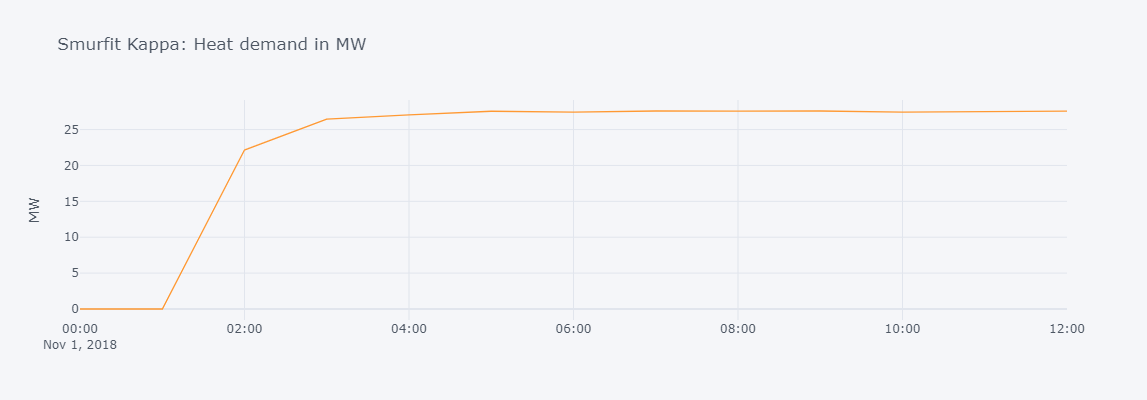

In [56]:
data['Total demand'] = data['MW (VDG)'] + data['MW (NDG)']
data = data[start:end]
fig_demands_nov2018 = data['Total demand'].resample('1H').mean().iplot(
    title='Smurfit Kappa: Heat demand in MW', 
    yTitle='MW', 
    asFigure=True,
    dimensions=(800, 400)
)
fig_demands_nov2018

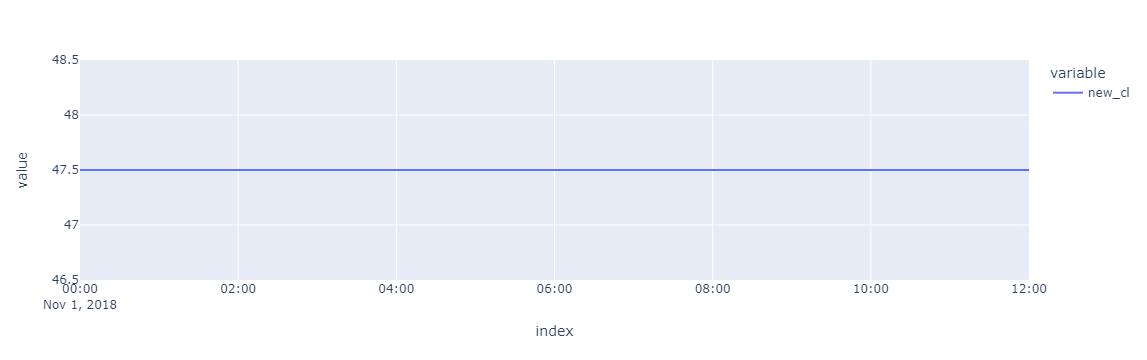

In [57]:
import plotly.express as px

fig = px.line(df['new_cl'])
fig.show()

In [58]:
df.index = df.index.tz_localize('Europe/Amsterdam')

In [59]:
for col in price_data.columns:
    df[col] = price_data[col]

df['nomination_MWh'] = 10
df['heatpump_cons_MWh'] = 9
df['imbalance_MWh'] = df['nomination_MWh'] - df['heatpump_cons_MWh']
df['day-ahead costs'] = df['nomination_MWh'] * df['DAM'] 

is_pos = df['imbalance_MWh'] > 0
df.loc[is_pos, 'imbalance costs'] = -df.loc[is_pos, 'imbalance_MWh'] * df['POS'] 

is_neg = df['imbalance_MWh'] < 0
df.loc[is_neg, 'imbalance costs'] = -df.loc[is_neg, 'imbalance_MWh'] * df['NEG'] 

df['total cost'] = df['day-ahead costs'] + df['imbalance costs']

In [60]:
df.head()

Tsource (VDG)  Tsink (VDG)  MW (VDG)  \
2018-11-01 00:00:00+01:00      64.964783   142.003109       0.0   
2018-11-01 00:15:00+01:00      54.578777   138.960493       0.0   
2018-11-01 00:30:00+01:00      65.166672   139.885329       0.0   
2018-11-01 00:45:00+01:00      65.358078   139.731901       0.0   
2018-11-01 01:00:00+01:00      64.947536   139.577871       0.0   

                           Tsource (NDG)  Tsink (NDG)  MW (NDG)    hp_mass  \
2018-11-01 00:00:00+01:00      19.897433   147.731814       0.0  52.101451   
2018-11-01 00:15:00+01:00      17.950905   148.138964       0.0  53.242241   
2018-11-01 00:30:00+01:00      33.500757   147.585426       0.0  52.890236   
2018-11-01 00:45:00+01:00      42.203876   147.547612       0.0  52.948310   
2018-11-01 01:00:00+01:00      18.702675   148.260335       0.0  53.006741   

                           process_mass                   COP  charge_mass  \
2018-11-01 00:00:00+01:00     42.017299   (5.386969459992516)    10.084152   
2018-11-01 00:15:00+01:00     42.937291   (4.882106135030027)    10.304950   
2018-11-01 00:30:00+01:00     42.653416  (5.5258665771869335)    10.236820   
2018-11-01 00:45:00+01:00     42.700250   (5.549424302045392)    10.248060   
2018-11-01 01:00:00+01:00     42.747372   (5.528286493353138)    10.259369   

                           ...  new_cl    DAM    POS    NEG  nomination_MWh  \
2018-11-01 00:00:00+01:00  ...    47.5  44.90  46.39  46.39              10   
2018-11-01 00:15:00+01:00  ...    47.5  44.90  43.08  43.08              10   
2018-11-01 00:30:00+01:00  ...    47.5  44.90  43.13  43.13              10   
2018-11-01 00:45:00+01:00  ...    47.5  44.90  46.29  46.29              10   
2018-11-01 01:00:00+01:00  ...    47.5  42.46  32.03  32.03              10   

                           heatpump_cons_MWh  imbalance_MWh  day-ahead costs  \
2018-11-01 00:00:00+01:00                  9              1            449.0   
2018-11-01 00:15:00+01:00                  9              1            449.0   
2018-11-01 00:30:00+01:00                  9              1            449.0   
2018-11-01 00:45:00+01:00                  9              1            449.0   
2018-11-01 01:00:00+01:00                  9              1            424.6   

                           imbalance costs  total cost  
2018-11-01 00:00:00+01:00           -46.39      402.61  
2018-11-01 00:15:00+01:00           -43.08      405.92  
2018-11-01 00:30:00+01:00           -43.13      405.87  
2018-11-01 00:45:00+01:00           -46.29      402.71  
2018-11-01 01:00:00+01:00           -32.03      392.57  

[5 rows x 23 columns]